In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
from imutils import paths
import numpy as np
import sys
import cv2
import os

sys.path.append("..")

from bodypose.training.metrics import avgMDE_2D, avgMDE_2D_RAW, Accuracy
from bodypose.training.metrics import AuxiliaryLoss
from bodypose.training.preprocessing import load_TFRecords_dataset  
from bodypose.training.preprocessing import augmentations
from bodypose.training.architecture import MoveNet
from bodypose.demo.graphics import draw_keypoints
from bodypose.training.architecture.custom_layers import get_max_mask

import config as cfg

In [2]:
INPUT_SHAPE = (224, 224, 3)
STRIDES = (32, 16, 8, 4)
NUM_KPTS = len(cfg.MPII_KEYPOINT_DICT)

GRID_SIZE = INPUT_SHAPE[0] // STRIDES[-1]

In [3]:
filePaths = list(paths.list_files("../dataset/tfrecords/mpii/validation/"))
print(f"[INFO] Found {len(filePaths)} TFRecords.")

ds = load_TFRecords_dataset(
    filePaths=filePaths, 
    batch_size = 10,
    target_size = INPUT_SHAPE[:2],
    grid_dim = GRID_SIZE,
    augmentations = [],
    roi_thresh = 0.9
    )

[INFO] Found 10 TFRecords.


2022-11-08 10:12:19.730442: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
model = MoveNet(
    input_shape = INPUT_SHAPE, 
    strides = STRIDES, 
    num_joints = NUM_KPTS, 
    alpha = .5, 
    use_depthwise = True,
    debug=True
    )

img = (np.random.uniform(
    0, 255, (1,) + INPUT_SHAPE
    ).astype("uint8") / 255).astype(np.float32)

%timeit model(img)

84.7 ms ± 355 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [5]:
model.summary()

Model: "move_net"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 backbone (Functional)       [(None, 7, 7, 1280),      706224    
                              (None, 14, 14, 288),               
                              (None, 28, 28, 96),                
                              (None, 56, 56, 96)]                
                                                                 
 FPN (Functional)            (None, 56, 56, 64)        113920    
                                                                 
 head (Functional)           (None, 3136, 17)          21137     
                                                                 
Total params: 841,281
Trainable params: 821,713
Non-trainable params: 19,568
_________________________________________________________________


In [6]:
for img, y in ds.take(1):
    heatmaps = model(img)
    print(y.shape)
    print(heatmaps.shape)

(10, 3136, 17)
(10, 3136, 17)


In [7]:
def draw_sample(i):
    sample = ((img[i].numpy() + 1) * 127.5).astype('uint8').copy()

    heatmaps = model.predict(img[i:i+1])
    
    # Heatmaps
    kptsmap = heatmaps[0, :, 1:].sum(axis=-1).reshape(GRID_SIZE, GRID_SIZE)
    kptsmap = cv2.resize(kptsmap, INPUT_SHAPE[:2])

    centremap = heatmaps[0, :, 0].reshape(GRID_SIZE, GRID_SIZE)
    centremap = cv2.resize(centremap, INPUT_SHAPE[:2])

    # Labels
    center_label = y[i, :, 0].numpy().reshape(GRID_SIZE, GRID_SIZE)
    center_label = cv2.resize(center_label, INPUT_SHAPE[:2])

    kpts_label = y[i, :, 1:].numpy().sum(axis=-1).reshape(GRID_SIZE, GRID_SIZE)
    kpts_label = cv2.resize(kpts_label, INPUT_SHAPE[:2])
    

    fig, axs = plt.subplots(2, 2)
    fig.set_figheight(20)
    fig.set_figwidth(20)

    axs[0,0].imshow(sample, alpha=.5)
    axs[0,0].imshow(center_label,  alpha=.5)
    axs[0,0].axis('off')
    axs[0,0].set_title("Label - CentreMap")

    axs[0,1].imshow(sample, alpha=.5)
    axs[0,1].imshow(centremap,  alpha=.5)
    axs[0,1].axis('off')
    axs[0,1].set_title("Predicted - CentreMap")

    axs[1,0].imshow(sample, alpha=.5)
    axs[1,0].imshow(kpts_label,  alpha=.5)
    axs[1,0].axis('off')
    axs[1,0].set_title("Label - KeypointsMap")

    axs[1,1].imshow(sample, alpha=.5)
    axs[1,1].imshow(kptsmap,  alpha=.5)
    axs[1,1].axis('off')
    axs[1,1].set_title("Preddicted - KeypointsMap")

1/1 [==============================] - 1s 1s/step


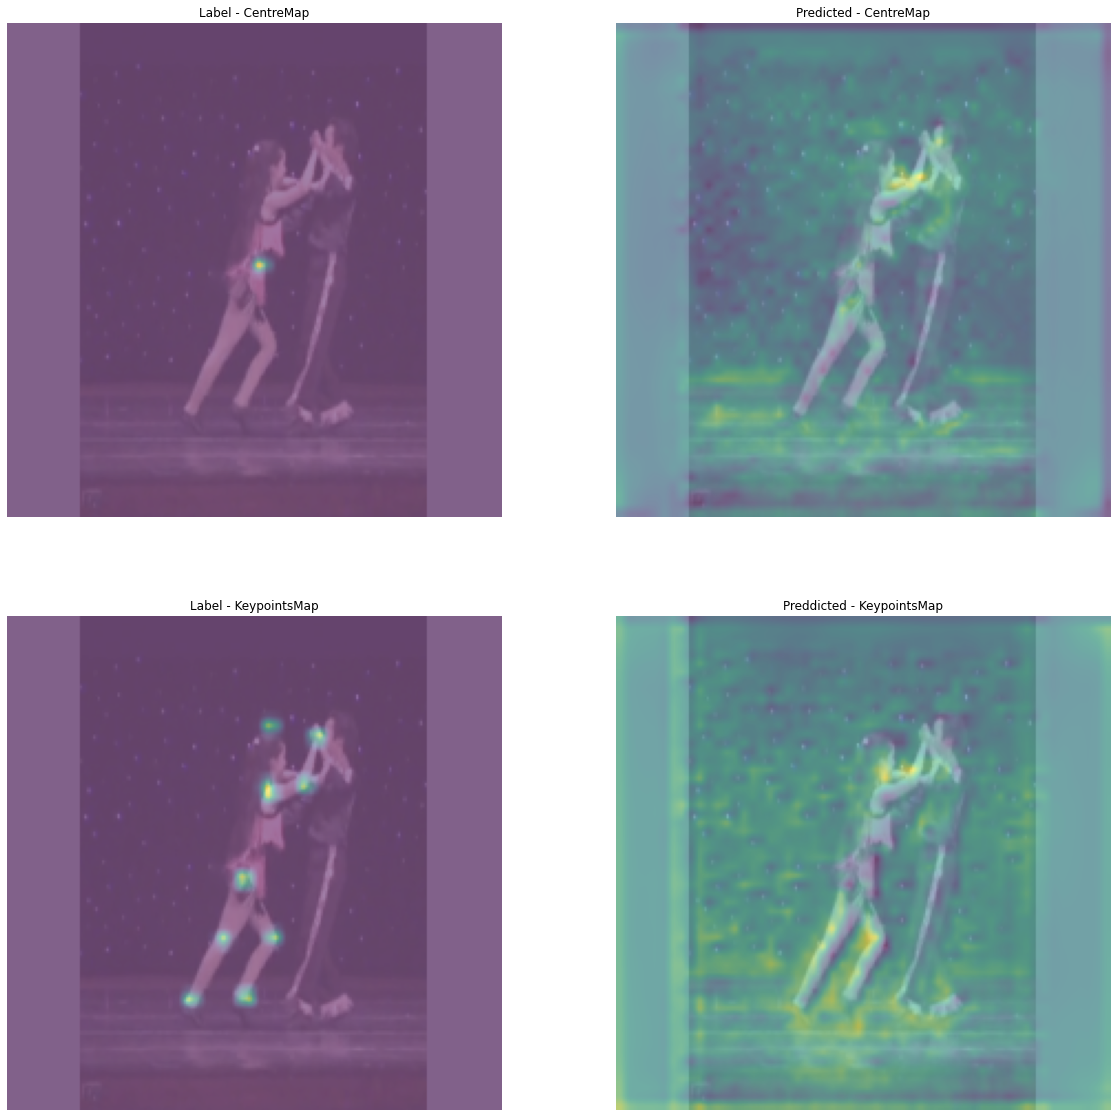

In [8]:
draw_sample(1)